### Fashion MNIST 데이터 기반으로 모델 생성 및 학습 수행
* FashionMNIST Dataset 생성, 변환, DataLoader 구성 
* Layer, 함수 그리고 Sequential을 활용한 네트웍 모델 생성하기
* Loss와 Optimizer 이해
* Training 로직(루프) 만들기
    * Pytorch는 신경망 모델 생성과 학습(Training) 로직이 Loosely Coupled 되어 있음.
    * 모델은 batch 단위로 입력된 학습 데이터 입력 tensor를 받아서 모델 구조에 맞춰서 출력 tensor로 변환하고 이를 반환하는데 촛점(Computational Graph 생성)
    * Training 로직은 모델의 출력 tensor값을 Loss 함수 및 Optimizer를 이용하여 backpropagation 기반으로 Weight(가중치) 파라미터를 Update 수행. 학습 데이터의 batch 단위로 반복 수행 하며, 전체 학습 데이터를 epochs 지정된 횟수만큼 수행.
  

#### Fashion MNIST Dataset 생성
* torchvision.datasets에서 FashionMNIST Dataset 다운로드
* FashionMNIST Dataset은 train=True이면 학습 Dataset, train=False이면 테스트 Dataset으로 만들어짐
* 이미지 데이터가 PIL 형태로 되어 있음. torchvision.transforms의 ToTensor()를 이용하여 PIL을 tensor로 변환 필요. 

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(root='data', train=True, download=True)#,transform=ToTensor()
test_data = datasets.FashionMNIST(root='data', train=False, download=True)#,transform=ToTensor()

In [3]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [4]:
print(type(train_data[0]))

<class 'tuple'>


In [5]:
# 개별 Fashion MNIST 데이터는 PIL Image와 Label/Target 값 Tuple로 구성됨. 
print(train_data[0])
print(type(train_data[0]))
print(type(train_data[0][0]))
print(len(train_data))

(<PIL.Image.Image image mode=L size=28x28 at 0x104208D10>, 9)
<class 'tuple'>
<class 'PIL.Image.Image'>
60000


In [6]:
train_data[0][0]

In [7]:
len(test_data)

10000

In [8]:
print(type(train_data.data), train_data.data.shape)

<class 'torch.Tensor'> torch.Size([60000, 28, 28])


### Fashion MNIST 이미지 시각화 하기

Text(0.5, 1.0, '9')

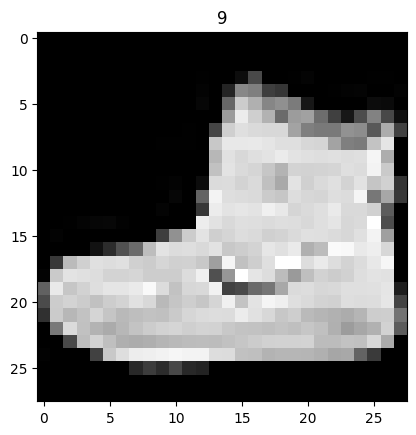

In [9]:
import matplotlib.pyplot as plt

train_image = train_data[0][0]
train_label = train_data[0][1]

#PIL Image를 시각화 하기
plt.imshow(train_image, cmap='gray')
plt.title(train_label)

In [10]:
train_images = [image for image, _ in train_data]
train_labels = [label for _, label in train_data]

In [11]:
type(train_images[0])

PIL.Image.Image

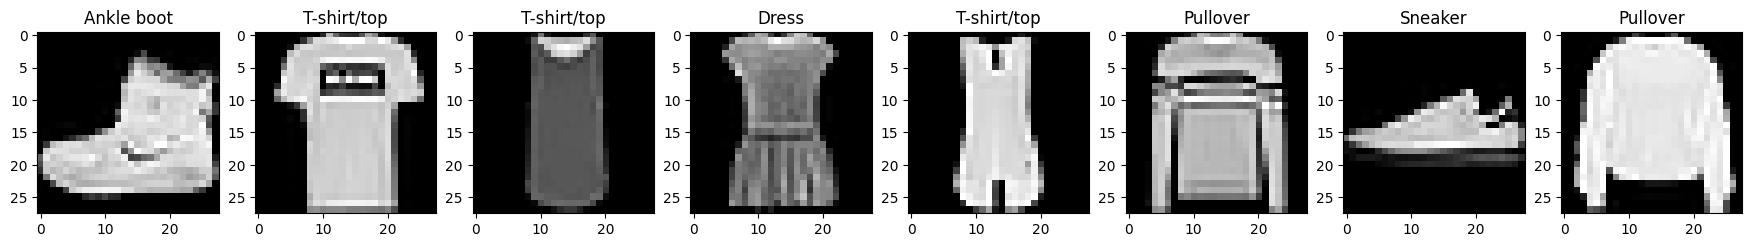

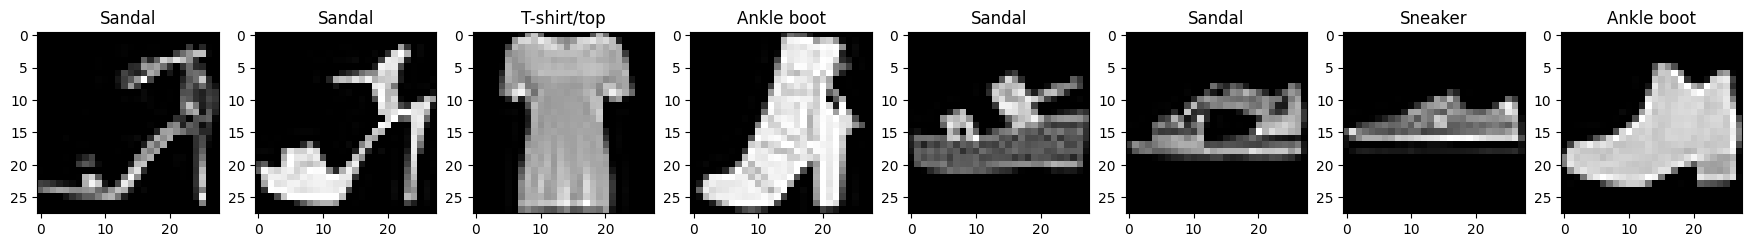

In [12]:
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(class_names[labels[i]])
        
show_images(train_images[:8], train_labels[:8], ncols=8)
show_images(train_images[8:16], train_labels[8:16], ncols=8)

### Dataset를 Batch 단위로 Fetch하는 DataLoader 생성.
* DataLoader는 Dataset을 Batch 단위로 효과적이고 빠르게 모델에 전달하기 위한 역할을 수행
    * dataset: 읽어들일 dataset 객체
    * batch_size: 한번에 읽어들인 batch 크기
    * shuffle: Training loop에서 epoch 완료 시마다 데이터를 섞을 지 여부
    * num_workers: 로딩 병렬 작업 workers
* DataLoader는 출력은 tensor 형태로 고정됨이 바람직. 

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# DataLoader 생성
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [ ]:
# 아래는 다음과 같은 오류 발생. DataLoader는 PIL이미지를 Batch화 시킬 수 없음.
# TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>
images, labels = next(iter(train_loader))
print(images.shape, images.dtype, labels.shape, labels.dtype)

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# DataLoader의 반환값이 Tensor가 되도록 datasets.FashionMNIST 다운로드시 transform인자로 torchvision.transforms의 ToTensor() 적용
train_data = datasets.FashionMNIST(root='data',train= True, download=True, transform=ToTensor())
val_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())

# Dataset을 인덱싱으로 접근해서 가져갈 때마다 ToTensor()가 호출됨.  
print('train_data image, label type:', type(train_data[0][0]), type(train_data[0][1]))

BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))
print(images.shape, images.dtype, labels.shape, labels.dtype)

train_data image, label type: <class 'torch.Tensor'> <class 'int'>
torch.Size([32, 1, 28, 28]) torch.float32 torch.Size([32]) torch.int64


In [ ]:
images#images[0], images[0].shape

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

### Linear Model을 생성
* Linear Model은 4차원으로 되어 있는 image batch tensor를 입력 받아서, 10개의 classification logit output을 만들어냄.
* Linear Layer Model은 배치를 포함한 2차원 형태를 받아들이므로 개별 3차원 이미지(Grayscale image이므로 원래는 2차원 이미지 이지만, 이미지 자체를 3차원으로 표현)를 1차원 형태로 변환해야함. 이를 위해 nn.Flatten()을 적용.
* Linear, Activation function 들을 모두 Layer로 선언한 뒤 이를 forward에서 이어 붙이는 방식, Linear 등 weight를 가지는 Layer들만 Layer로 선언하고 activation function, pooling 등은 functional 함수로 이어 붙이는 방식, Sequential을 활용하는 방식등으로 모델 구성. 

### Layer 기반으로 모델 생성
* Linear Layer 뿐만 아니라 Activation도 Layer로 생성
* Image Input Flatten -> Linear(input_size*input_size, 200)->ReLU->Linear(200, 100)->ReLU->Linear(100, num_classes)

In [ ]:
import torch
import torch.nn as nn

# Flatten 적용해보기
flatten = nn.Flatten()
flatten_output = flatten(images)
print(images.shape, flatten_output.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32, 784])


In [ ]:
class SimpleLinearModel_01(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_01 = nn.Linear(in_features=input_size*input_size, out_features=200)
        self.act_01 = nn.ReLU()
        self.linear_02 =nn.Linear(in_features=200, out_features=100)
        self.act_02 = nn.ReLU()
        self.linear_03 = nn.Linear(100, num_classes)
        
    # 입력 tensor -> Layer 적용된 출력 tensor -> 다음 Layer에 입력 tensor로 적용 -> ... -> 최종 출력 tensor 반환
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_01(x)
        x = self.act_01(x)
        x = self.linear_02(x)
        x = self.act_02(x)
        output = self.linear_03(x)
        # 반드시 tensor가 layer를 통과하면서 적용된 최종 tensor를 반환한다. 
        return output

In [ ]:
INPUT_SIZE = 28
NUM_CLASSES = 10 

model_01 = SimpleLinearModel_01(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)
print(model_01)

SimpleLinearModel_01(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_01): Linear(in_features=784, out_features=200, bias=True)
  (act_01): ReLU()
  (linear_02): Linear(in_features=200, out_features=100, bias=True)
  (act_02): ReLU()
  (linear_03): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
#임의의 tensor를 입력
input_tensor = torch.randn(4, 1, 28, 28)
output = model_01(input_tensor)

print(output.shape)

torch.Size([4, 10])


In [ ]:
BATCH_SIZE = 32

# batch size만큼의 입력 Tensor를 모델에 입력 후 출력 Tensor의 shape확인
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))

print(images.shape)
output = model_01(images)
print(output.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
from torchinfo import summary

summary(model=model_01, input_size=(1, 1, 28, 28), 
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['var_names', 'depth'],
       )

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #
SimpleLinearModel_01 (SimpleLinearModel_01)   [1, 1, 28, 28]            [1, 10]                   --
├─Flatten (flatten): 1-1                      [1, 1, 28, 28]            [1, 784]                  --
├─Linear (linear_01): 1-2                     [1, 784]                  [1, 200]                  157,000
├─ReLU (act_01): 1-3                          [1, 200]                  [1, 200]                  --
├─Linear (linear_02): 1-4                     [1, 200]                  [1, 100]                  20,100
├─ReLU (act_02): 1-5                          [1, 100]                  [1, 100]                  --
├─Linear (linear_03): 1-6                     [1, 100]                  [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

### Linear만 Layer로, activation은 relu()함수를 적용하여 모델 생성

In [19]:
import torch.nn.functional as F

class SimpleLinearModel_02(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        # nn.Linear는 Layer를 그대로 사용. Linear Layer는 내부적으로 weight, bias등의 learnable parameter 값을 가지고 있기 때문
        # 또한 모델 구성이 좀 더 가득성있고 편리하게 적용 가능. 
        self.linear_01 = nn.Linear(input_size * input_size, 200)
        self.linear_02 = nn.Linear(200, 100)
        self.linear_03 = nn.Linear(100, num_classes)

     # 입력 tensor -> Layer 적용된 출력 tensor -> 다음 Layer에 입력 tensor로 적용 -> ... -> 최종 출력 tensor 반환
    def forward(self, x):
        # nn.Flatten()과 달리 torch.flatten()의 start_dim의 default 값은 0임. batch를 고려하여 flatten되도록 start_dim=1로 설정
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        x = F.relu(self.linear_01(x))
        x = F.relu(self.linear_02(x))
        output = self.linear_03(x)

        #또는 아래와 같이 축약해서 사용할 수도 있음. 가독성이 떨어지므로 사용 자제
        #x = torch.flatten(x, start_dim=1, end_dim=-1)
        #output = self.linear_03(F.relu(self.linear_02(F.relu(self.linear_01(x))))) 

        # layer들을 통과하면서 적용된 최종 tensor를 반환한다. 
        return output
        

In [ ]:
INPUT_SIZE = 28
NUM_CLASSES = 10

print(images.shape)
model_02 = SimpleLinearModel_02(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)

output = model_02(images)
print(output.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [ ]:
from torchinfo import summary

summary(model=model_02, input_size=(1, 1, 28, 28), 
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['var_names', 'depth'],
        #verbose=2
       )

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #
SimpleLinearModel_02 (SimpleLinearModel_02)   [1, 1, 28, 28]            [1, 10]                   --
├─Linear (linear_01): 1-1                     [1, 784]                  [1, 200]                  157,000
├─Linear (linear_02): 1-2                     [1, 200]                  [1, 100]                  20,100
├─Linear (linear_03): 1-3                     [1, 100]                  [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.71
Estimated Total Size (MB): 0.72

### Sequential을 이용하여 모델 만들기
* Sequential은 인자로 들어온 Layer나 Module들을 Sub Module하여 연속적으로 연결 시켜서 모듈화 시킬 수 있음
* 반복되는 Layer들의 연결을 forward() 메소드에서 기술하지 않고, 블록 단위로 모듈을 효율적으로 생성할 수 있음.

In [ ]:
import torch.nn.functional as F

# Sequential을 이용하여 모델 구성.
class SimpleLinearModel_03(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        # Sequential()의 인자로 Layer또는 Sub module 입력. 
        self.linear_block_01 = nn.Sequential(nn.Linear(in_features=input_size*input_size, out_features=200),
                                              nn.ReLU(), 
                                              nn.Linear(200, 100),
                                              nn.ReLU(),
                                              nn.Linear(100, num_classes)
                                            )

    # 입력 tensor -> Layer 적용된 출력 tensor -> 다음 Layer에 입력 tensor로 적용 -> ... -> 최종 출력 tensor 반환
    def forward(self, x):
        # nn.Flatten()과 달리 torch.flatten()의 start_dim의 default 값은 0임. batch를 고려하여 flatten되도록 start_dim=1로 설정
        x = torch.flatten(x, start_dim=1, end_dim=-1)
        output = self.linear_block_01(x)

        # layer들을 통과하면서 적용된 최종 tensor를 반환한다. 
        return output

In [ ]:
INPUT_SIZE = 28
NUM_CLASSES = 10 

model_03 = SimpleLinearModel_03(input_size=INPUT_SIZE, num_classes=NUM_CLASSES)
output = model_03(images)
print(output.shape)

torch.Size([32, 10])


In [ ]:
summary(model=model_03, input_size=(1, 1, 28, 28), 
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['var_names', 'depth'],
        #verbose=2
       )

Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #
SimpleLinearModel_03 (SimpleLinearModel_03)   [1, 1, 28, 28]            [1, 10]                   --
├─Sequential (linear_block_01): 1-1           [1, 784]                  [1, 10]                   --
│    └─Linear (0): 2-1                        [1, 784]                  [1, 200]                  157,000
│    └─ReLU (1): 2-2                          [1, 200]                  [1, 200]                  --
│    └─Linear (2): 2-3                        [1, 200]                  [1, 100]                  20,100
│    └─ReLU (3): 2-4                          [1, 100]                  [1, 100]                  --
│    └─Linear (4): 2-5                        [1, 100]                  [1, 10]                   1,010
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

#### SimpleLinearModel 을 생성하는 함수 선언
* create_simple_linear_model() 함수로 모델 생성 후 반환

In [16]:
INPUT_SIZE = 28
NUM_CLASSES = 10

def create_simple_linear_model(input_size, num_classes=10):
    model = SimpleLinearModel_02(input_size=input_size, num_classes=num_classes)
    return model

In [17]:
BATCH_SIZE = 32

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# DataLoader의 반환값이 Tensor가 되도록 datasets.FashionMNIST 다운로드시 transform인자로 torchvision.transforms의 ToTensor() 적용
train_data = datasets.FashionMNIST(root='data',train= True, download=True, transform=ToTensor())
val_data = datasets.FashionMNIST(root='data',train= False, download=True, transform=ToTensor())

# batch size만큼의 입력 Tensor를 모델에 입력 후 출력 Tensor의 shape확인
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

images, labels = next(iter(train_loader))

print(images.shape)
print(labels)

torch.Size([32, 1, 28, 28])
tensor([3, 6, 0, 7, 7, 8, 3, 2, 8, 3, 5, 4, 6, 8, 8, 6, 6, 2, 4, 8, 1, 7, 9, 6,
        7, 0, 5, 6, 0, 4, 6, 1])


### Loss 함수(클래스)
* Multiclass의 예측 모델의 경우 Loss는 Cross entropy Loss 적용. pytorch는 이를 위해 CrossEntropyLoss 클래스를 제공
* CrossEntropyLoss는 입력으로 softmax가 적용되지 않은 logit 예측값과 Class Index 형태의 정수형 label(target)값을 받음(one-hot encoding 적용해서 입력하면 안됨)
* 클래스 내부에서 입력 logit값에 대해서 softmax를 적용하므로 반드시 softmax가 적용되지 않은 logit 예측 값을 입력해 줘야함.
* label(target)값의 경우 class 값(class index값 0 ~ C)으로 입력함. 클래스 내부에서 필요한 경우 one-hot encoding을 적용하므로, 입력 시에는 one-hot encoding을 적용해 주면 안됨.
* 따라서 입력 인자로 softmax를 적용하지 않은 모델 출력값, one-hot encoding을 적용하지 않은 label(target) 값을 입력해 줌.
* CrossEntropyLoss 클래스는 LogSoftmax와 NLLLoss가 결합된 형태임 LogSoftmax는 softmax에 log를 순차적으로 적용시 발생 할 수 있는 수치 불안정한 현상을 개선하여 Cross Entropy Loss 계산을 보다 안정적으로 수행 할 수 있게함. 
* CrossEntropyLoss의 출력은 계산된 Loss값을 가지고 있는 tensor임. loss tensor의 backward()메소드를 호출하면 Backpropagation을 수행하여 Gradient 값을 계산함. 학습 파라미터들은 적용될 Gradient값을 grad 속성에 가지고 있지만, 학습파라미터를 Update하지는 않음. 실제 Update는 Optimizer 에서 수행.  

In [20]:
model = create_simple_linear_model(input_size=28, num_classes=10)
# 모델 출력(logit 값 출력)
output = model(images)

#criterion = nn.CrossEntropyLoss()
# CrossEntropyLoss 객체 생성. 
loss_fn = nn.CrossEntropyLoss()
# 모델의 출력값을 첫번째 인자로, labels 값을 두번째 인자로 입력.
loss = loss_fn(output, labels)
print(loss, loss.item())

tensor(2.3118, grad_fn=<NllLossBackward0>) 2.311757802963257


In [ ]:
print("Before backward():")
for name, param in model.named_parameters():
    print(f"{name}.grad: {param.grad}")

Before backward():
linear_01.weight.grad: None
linear_01.bias.grad: None
linear_02.weight.grad: None
linear_02.bias.grad: None
linear_03.weight.grad: None
linear_03.bias.grad: None


In [ ]:
loss.backward()

In [ ]:
print(loss)

tensor(2.3034, grad_fn=<NllLossBackward0>)


In [ ]:
print("After backward():")
for name, param in model.named_parameters():
    print(f"{name}.grad: {param.grad}")

After backward():
linear_01.weight.grad: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5130e-04,
         -1.0854e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.2047e-06,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.4372e-04,
         -1.0506e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.8056e-05,
          3.4475e-05,  0.0000e+00]])
linear_01.bias.grad: tensor([-1.7917e-03,  1.8554e-03, -1.1963e-03,  9.7032e-05, -4.8209e-03,
        -1.4740e-03, -1.6421e-03, -6.1733e-04, -1.6547e-04, -3.3368e-04,
        -4.0641e-03,  2.4103e-03,  3.5170e-03, -2.0568e-03, -4.3742e-03,
        -1.3403e-04,  1.3280e-03,  4.0586e-03,  1.3014e-03,  6.5254e-04,
        -8.196

### Optimizer 생성
* pytorch의 torch.optim의 여러 클래스들은 다양한 Optimizer 기능을 제공
* optimizer 클래스의 생성 인자로 model의 parameter들과 학습률(learning rate)을 입력
* zero_grad() 메소드는 학습 파라미터의 grad 값을 초기화
* step() 메소드는 학습 파라미터를 업데이트 시킴

In [21]:
from torch.optim import SGD, Adagrad, RMSprop, Adam

sgd_optim = SGD(model.parameters(), lr=0.001, momentum=0.9)
ada_grad_optim = Adagrad(model.parameters(), lr=0.001, eps=1e-9)
rmsprop_optim = RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-9)
adam_optim = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
# adam_optim.zero_grad() # gradient 값을 초기화. 수행하지 않으면 gradient값이 계속 누적 계산됨.
# loss.backward() # backpropagation으로 학습 파라미터에 적용될 gradient 값 계산
# adam_optim.step() # gradient 값을 학습 파라미터에 적용. 

In [22]:
model = create_simple_linear_model(input_size=28, num_classes=10)
# 모델 출력(logit 값 출력)
output = model(images)

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(output, labels)

optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

params = list(model.parameters())
print('### gradients in initial state:', params[0].grad)
# print('### params[0] in initial state:', params[0])

loss.backward()
print('### gradient after loss.backward():', params[0].grad)
# print('### params[0] after loss.backward():', params[0])

# optimizer.step()
# print("### params[0] after optimizer.step():", params[0])

optimizer.zero_grad()
print('### gradient after optimizer.zero_grad():', params[0].grad)

### gradients in initial state: None
### gradient after loss.backward(): tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  6.9895e-07,  ...,  8.0349e-04,
          1.9376e-04,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.7244e-04,
         -8.9835e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
### gradient after optimizer.zero_grad(): None


### device 설정하기
* pytorch는 사용자가 GPU 또는 CPU를 사용할 지 명확하게 기술해 줘야함. 기술되지 않으면 기본적으로 CPU를 사용하며 모델 학습 및 예측을 수행.
* 이를 위해 pytorch는 torch.device 객체를 모델과 모델과 Loss에 입력하는 tensor에 device를 기술해 줘야함(이외에 torchemetric을 사용하는 경우라면 metric에 device를 지정해 줘야하는등의 경우가 있지만, 기본적으로는 모델 자체와 모델에 입력하는 tensor에 device를 지정해 줘야함)

In [ ]:
# tensor의 device는 기본적으로 cpu임. 
images, labels = next(iter(train_loader))
print(type(images), images.device, type(labels), labels.device)

In [23]:
# 아래를 수행하기 전에 kaggle notebook의 Accelerate를 GPU로 설정. 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, type(device))

images, labels = next(iter(train_loader))
print(type(images), images.device, type(labels), labels.device)

images = images.to(device)
labels = labels.to(device)
print(type(images), images.device, type(labels), labels.device)

cpu <class 'torch.device'>
<class 'torch.Tensor'> cpu <class 'torch.Tensor'> cpu
<class 'torch.Tensor'> cpu <class 'torch.Tensor'> cpu


### model과 입력 tensor 모두 동일한 device에 있는 것이 중요. 서로 다른 device에 있을 경우 오류 발생. 

In [ ]:
# 학습 데이터에서 image와 labels을 batch size 만큼 추출 
images, labels = next(iter(train_loader))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_simple_linear_model(input_size=28, num_classes=10)
model = model.to(device)
# model은 device가 cuda:0 이지만, images는 cpu임. 
print('image tensor device:', images.device) # model의 device는 model내 parameter의 device로 호출. next(model.parameters()).device)

# images를 to('cuda') 하여야 오류 발생하지 않음. 
#images = images.to(device)
#print(images.device)

# 아래 코드는 오류를 발생. model의 device가 cuda인데, model에 입력하는 tensor의 device가 cpu가 될 수 없음.  
pred = model(images)

### Training 로직(루프) 만들기
* Pytorch는 신경망 모델 생성과 학습(Training) 로직이 Loosely Coupled 되어 있음.
* 모델은 batch 단위로 입력된 학습 데이터 입력 tensor를 받아서 모델 구조에 맞춰서 출력 tensor로 변환하고 이를 반환하는데 촛점(Computational Graph 생성)
* Training 로직은 모델의 출력 tensor값을 Loss 함수 및 Optimizer를 이용하여 backpropagation 기반으로 Weight(가중치) 파라미터를 Update 수행. 학습 데이터의 batch 단위로 반복 수행 하며, 전체 학습 데이터를 epochs 지정된 횟수만큼 수행.
* model은 training 모드임을 설정한 뒤(model.train()) training 시작. Batch Normalization이나 Drop Out 설정 시 검증/예측 모드와는 다르게 모델이 동작해야 하기 때문임.
  
![](https://github.com/chulminkw/CNN_PG_Torch/blob/main/image/Training_Loop.png?raw=true)

In [24]:
# 학습 데이터에서 image와 labels을 BATCH_SIZE 만큼 추출 
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4 )

images, labels = next(iter(train_loader))
images.shape, images.dtype, labels.shape, labels.dtype

(torch.Size([32, 1, 28, 28]), torch.float32, torch.Size([32]), torch.int64)

In [25]:
import torch
import torch.nn as nn
from torch.optim import Adam

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# training loop에 들어가기 전에 model에 device 설정하는 것이 좋음. 
model.to(device)

# train 모드 설정 
model.train()

# 미니 배치 형태로 train loop 수행. train dataset은 60,000개, 
for batch_idx, (images, labels) in enumerate(train_loader):
    # 모델 입력 데이터 device 설정.
    images = images.to(device)
    labels = labels.to(device)

    # 이미지 tensor를 모델에 입력하여 출력 tensor(logit tensor) 출력  
    pred = model(images)
   
    # loss 계산. CrossEntropyLoss는 내부에서 소프트맥스를 적용하므로 모델의 출력 결과에 소프트맥스를 적용하지 않아야 함. 
    loss = loss_fn(pred, labels)

    # optimizer 초기화
    optimizer.zero_grad()
    
    # backpropagation으로 Gradient 계산
    loss.backward()
    
    # optimizer가 학습 파라미터 Update
    optimizer.step()
    
    if batch_idx % 100 == 0:
        print(f'{batch_idx+1} 번째 gradient update 수행중, loss는 {loss.item()}')

1 번째 gradient update 수행중, loss는 2.2976982593536377
101 번째 gradient update 수행중, loss는 0.7576976418495178
201 번째 gradient update 수행중, loss는 0.5119157433509827
301 번째 gradient update 수행중, loss는 0.8123482465744019
401 번째 gradient update 수행중, loss는 0.6440306305885315
501 번째 gradient update 수행중, loss는 0.6796685457229614
601 번째 gradient update 수행중, loss는 0.5798084735870361
701 번째 gradient update 수행중, loss는 0.6170673966407776
801 번째 gradient update 수행중, loss는 0.5279263854026794
901 번째 gradient update 수행중, loss는 0.35698163509368896
1001 번째 gradient update 수행중, loss는 0.44524189829826355
1101 번째 gradient update 수행중, loss는 0.4812728464603424
1201 번째 gradient update 수행중, loss는 0.4569271504878998
1301 번째 gradient update 수행중, loss는 0.6402689218521118
1401 번째 gradient update 수행중, loss는 0.42868468165397644
1501 번째 gradient update 수행중, loss는 0.5299511551856995
1601 번째 gradient update 수행중, loss는 0.5428129434585571
1701 번째 gradient update 수행중, loss는 0.26848939061164856
1801 번째 gradient update 수행중, loss는 0

#### 함수로 생성

In [26]:
# 1 epoch 동안 train dataset을 미니 배치 단위로 모델을 학습 시킴. 
def train_step():
    # 미니 배치 형태로 train loop 수행. train dataset은 60,000개
    for batch_idx, (images, labels) in enumerate(train_loader):
        # 모델 입력 데이터 device 설정. 
        images = images.to(device)
        labels = labels.to(device)
        
        # 이미지 tensor를 모델에 입력하여 출력 tensor(logit tensor) 출력  
        pred = model(images)
        
        # loss 계산. CrossEntropyLoss는 내부에서 소프트맥스를 적용하므로 모델의 출력 결과에 소프트맥스를 적용하지 않아야 함. 
        loss = loss_fn(pred, labels)

        #optimizer 초기화
        optimizer.zero_grad()
        
        #backpropagation으로 Gradient 계산
        loss.backward()
        
        #optimizer가 학습 파라미터 Update
        optimizer.step()
        
        # 100 loop시 마다 아래 출력
        if batch_idx % 100 == 0:
            print(f'{batch_idx+1} 번째 batch gradient 적용, loss는 {loss.item()}')

train_step()

1 번째 batch gradient 적용, loss는 0.6938162446022034
101 번째 batch gradient 적용, loss는 0.348589688539505
201 번째 batch gradient 적용, loss는 0.16002213954925537
301 번째 batch gradient 적용, loss는 0.4838063716888428
401 번째 batch gradient 적용, loss는 0.3785673677921295
501 번째 batch gradient 적용, loss는 0.41460978984832764
601 번째 batch gradient 적용, loss는 0.3954102694988251
701 번째 batch gradient 적용, loss는 0.2778903543949127
801 번째 batch gradient 적용, loss는 0.49124544858932495
901 번째 batch gradient 적용, loss는 0.2008000612258911
1001 번째 batch gradient 적용, loss는 0.2410466969013214
1101 번째 batch gradient 적용, loss는 0.47854527831077576
1201 번째 batch gradient 적용, loss는 0.444202721118927
1301 번째 batch gradient 적용, loss는 0.5956094264984131
1401 번째 batch gradient 적용, loss는 0.5749620795249939
1501 번째 batch gradient 적용, loss는 0.6672629117965698
1601 번째 batch gradient 적용, loss는 0.24317024648189545
1701 번째 batch gradient 적용, loss는 0.43577325344085693
1801 번째 batch gradient 적용, loss는 0.27122125029563904


#### 여러 epochs 동안 training loop 반복

In [27]:
EPOCHS = 10

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# model에 device 설정
model = model.to(device)

# train 모드 설정 
model.train()

for epoch in range(EPOCHS):
    print(f"######## {epoch+1} 번째 train epoch 시작")
    train_step()

######## 1 번째 train epoch 시작
1 번째 batch gradient 적용, loss는 0.4039299488067627
101 번째 batch gradient 적용, loss는 0.19796788692474365
201 번째 batch gradient 적용, loss는 0.23422081768512726
301 번째 batch gradient 적용, loss는 0.5775916576385498
401 번째 batch gradient 적용, loss는 0.17856915295124054
501 번째 batch gradient 적용, loss는 0.2524421811103821
601 번째 batch gradient 적용, loss는 0.2781696915626526
701 번째 batch gradient 적용, loss는 0.44753801822662354
801 번째 batch gradient 적용, loss는 0.3502524495124817
901 번째 batch gradient 적용, loss는 0.32259055972099304
1001 번째 batch gradient 적용, loss는 0.26233986020088196
1101 번째 batch gradient 적용, loss는 0.3680242598056793
1201 번째 batch gradient 적용, loss는 0.3525160849094391
1301 번째 batch gradient 적용, loss는 0.22979041934013367
1401 번째 batch gradient 적용, loss는 0.0710383951663971
1501 번째 batch gradient 적용, loss는 0.30304840207099915
1601 번째 batch gradient 적용, loss는 0.2980533242225647
1701 번째 batch gradient 적용, loss는 0.41852349042892456
1801 번째 batch gradient 적용, loss는 0.315

### 검증 데이터 기반 evaluation 수행. 
* Training Loop 내에서 Batch 단위로 학습된 model에 대해서 Batch 단위 검증 데이터로 모델의 Loss 및 성능 메트릭을 출력하여 확인
* 학습 데이터의 성능 메트릭과 검증 데이터의 성능 메트릭을 비교하여 오버피팅이 어느 정도 진행되고 있는 확인
* model은 evaluation 모드임을 설정한 뒤(model.eval()) evaluation 시작. Batch Normalization이나 Drop Out 설정 시 학습 모드와는 다르게 모델이 동작해야 하기 때문임.
* evaluation은 모델의 출력값을 기반으로 하므로 별도의 Backpropagation을 Gradient Tracking이 필요하지 않음. 기본적으로 pytorch 모델은 Forward pass 시 Gradient Tracking을 requires_grad=True인 Tensor에 수행하므로 evaluation 시에는 수행 속도 향상을 위해서 이의 적용을 Disable 시킴. 이를 위해 with torch.no_grad() 컨텍스트를 적용.  

In [28]:
BATCH_SIZE = 32
# validation은 shuffle을 할 필요 없음. 일반적으로 속도 향상을 위해 BATCH_SIZE도 학습 시 보다 크게 설정. 
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# model에 device 설정
model = model.to(device)

# evaluation 모드 설정
model.eval()

# 모든 tensor가 Gradient Tracking을 하지 않도록 torch.no_grad() 컨텍스트를 적용. 
with torch.no_grad():
    # 미니 배치 형태로 검증 loop 수행.
    for batch_idx, (images, labels) in enumerate(val_loader):
        # 모델 입력 데이터 device 설정. 
        images = images.to(device)
        labels = labels.to(device)
        # 모델 출력
        pred = model(images)
        # 학습 loss와 비교하기 위해 loss 계산. loss만 계산하며 backprogation은 수행하지 않음. 
        loss = loss_fn(pred, labels)

        # 100회 마다 아래 출력
        if batch_idx % 100 == 0:
            print(f'{batch_idx} 번째 valid loss는 {loss.item()}')

0 번째 valid loss는 0.30266273021698
100 번째 valid loss는 0.26760828495025635
200 번째 valid loss는 0.27434566617012024
300 번째 valid loss는 0.17560608685016632


In [30]:
def val_step():
    with torch.no_grad():
        # 미니 배치 형태로 검증 loop 수행.
        for batch_idx, (images, labels) in enumerate(val_loader):
            # 모델 입력 데이터 device 설정. 
            images = images.to(device)
            labels = labels.to(device)
            # 모델 출력
            pred = model(images)
            # loss 계산
            loss = loss_fn(pred, labels)
    
            # 100회 마다 아래 출력
            if batch_idx % 100 == 0:
                print(f'{batch_idx} 번째 valid loss는 {loss.item()}')

#### 검증 데이터 evaluation을 적용한 Training Loop

In [31]:
EPOCHS = 10

optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# model에 device 설정
model = model.to(device)

for epoch in range(EPOCHS):
    # train 모드 설정 
    model.train()
    print(f"######## {epoch+1} 번째 train epoch 시작")
    train_step()

    # evaluation 모드 설정
    model.eval()
    print(f"######## {epoch+1} 번째 validation epoch 시작")
    val_step()

######## 1 번째 train epoch 시작
1 번째 batch gradient 적용, loss는 0.26603245735168457
101 번째 batch gradient 적용, loss는 0.07069289684295654
201 번째 batch gradient 적용, loss는 0.3076517879962921
301 번째 batch gradient 적용, loss는 0.12542521953582764
401 번째 batch gradient 적용, loss는 0.2429988980293274
501 번째 batch gradient 적용, loss는 0.23334600031375885
601 번째 batch gradient 적용, loss는 0.11451195925474167
701 번째 batch gradient 적용, loss는 0.24849656224250793
801 번째 batch gradient 적용, loss는 0.15787442028522491
901 번째 batch gradient 적용, loss는 0.42368853092193604
1001 번째 batch gradient 적용, loss는 0.2428923100233078
1101 번째 batch gradient 적용, loss는 0.15192337334156036
1201 번째 batch gradient 적용, loss는 0.17789509892463684
1301 번째 batch gradient 적용, loss는 0.15823759138584137
1401 번째 batch gradient 적용, loss는 0.22722084820270538
1501 번째 batch gradient 적용, loss는 0.3701518177986145
1601 번째 batch gradient 적용, loss는 0.16208244860172272
1701 번째 batch gradient 적용, loss는 0.16665120422840118
1801 번째 batch gradient 적용, loss는 

### 학습이 완료된 모델로 이미지 예측하기 

In [32]:
BATCH_SIZE = 32

# 테스트 데이터는 검증 데이터를 재 사용
test_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
images, labels = next(iter(test_loader))

In [33]:
# 여기서 model은 학습이 완료된 모델이어야 함. model device는 'cuda:0'. 
# model을 evaluation mode로 설정. 
model.eval()

with torch.no_grad():
    images = images.to(device)
    labels = labels.to(device)

    pred_logit = model(images)
    pred_class = F.softmax(pred_logit, dim=-1).argmax(-1)
    
print('model output shape:', pred_logit.shape)
print('predicted class:', pred_class, pred_class.shape)
print('targets:', labels, labels.shape)

#print('pred_logit[0]:', pred_logit[0])
#print('after softmax:', F.softmax(pred_logit[0], -1))
#print('after tensor argmax:', F.softmax(pred_logit[0], dim=-1).argmax(-1))

num_correct = (pred_class == labels).sum().item()
# print(pred_class == targets)
print(f'{images.size()[0]}개 데이터 중 {num_correct}개 예측 정확')

model output shape: torch.Size([32, 10])
predicted class: tensor([9, 2, 1, 1, 0, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 5,
        1, 2, 6, 0, 9, 0, 8, 8]) torch.Size([32])
targets: tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8]) torch.Size([32])
32개 데이터 중 28개 예측 정확


In [34]:
# 단일 이미지 예측. 
s_image = images[0] #.unsqueeze(0)
s_label = labels[0] #.unsqueeze(0)
print(s_image.shape, s_label.shape)

model.eval()

with torch.no_grad():
    s_image = s_image.to(device)
    s_label = s_label.to(device)

    pred_logit = model(s_image)
    pred_class = F.softmax(pred_logit, dim=-1).argmax(-1)

print(f'target class:{s_label}, predicted class: {pred_class}')

torch.Size([1, 28, 28]) torch.Size([])
target class:9, predicted class: tensor([9])


Text(0.5, 1.0, 'Ankle boot')

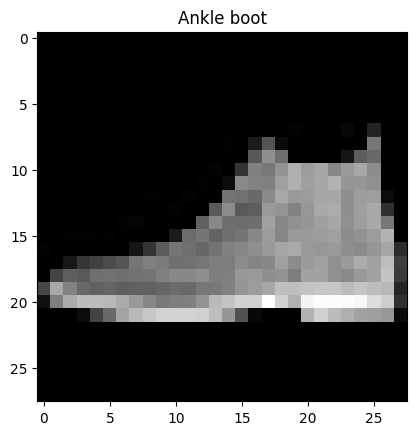

In [35]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#tensor를 PIL로 변환 
to_pil = ToPILImage()
pil_image = to_pil(images[0])

plt.imshow(pil_image, cmap='gray')
plt.title(class_names[pred_class.item()])